In [ ]:
import numpy as np
import os
import cv2
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, v2
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# CustomImageDataset class
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Augmentation pipeline for training set
augment_transform = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    v2.RandomGrayscale(p=0.1),
    v2.GaussianBlur(kernel_size=3, sigma=(0.5, 2.0)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Preprocessing for test and validation sets
test_transform = v2.Compose([
    v2.Resize(size=(224, 224), antialias=True),
    # v2.CenterCrop(size=(224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load both fire and non-fire datasets
fire_dir = '/content/drive/MyDrive/Flames_data/fire/Corrected FOV'
non_fire_dir = '/content/drive/MyDrive/Flames_data/non-fire/Corrected FOV'

image_paths = []
labels = []

if os.path.isdir(fire_dir):
    for filename in os.listdir(fire_dir):
        if filename.endswith(('.jpg', '.png', '.JPG')):
            image_paths.append(os.path.join(fire_dir, filename))
            labels.append(1)


if os.path.isdir(non_fire_dir):
    for filename in os.listdir(non_fire_dir):
        if filename.endswith(('.jpg', '.png', '.JPG')):
            image_paths.append(os.path.join(non_fire_dir, filename))
            labels.append(0)


print(f"Number of fire images found: {labels.count(1)}")
print(f"Number of non-fire images found: {labels.count(0)}")
print(f"Total number of images found: {len(image_paths)}")

# Split into training, validation, and testing sets
if len(image_paths) > 0:
    train_image_paths, test_image_paths, train_labels, test_labels = train_test_split(
        image_paths, labels, test_size=0.2, random_state=42, stratify=labels
    )

    train_image_paths, val_image_paths, train_labels, val_labels = train_test_split(
        train_image_paths, train_labels, test_size=0.25, random_state=42, stratify=train_labels
    )

    print(f"Number of images in training set: {len(train_image_paths)}")
    print(f"Number of images in validation set: {len(val_image_paths)}")
    print(f"Number of images in test set: {len(test_image_paths)}")

    # Create dataset instances
    train_dataset = CustomImageDataset(train_image_paths, train_labels, transform=augment_transform)
    val_dataset = CustomImageDataset(val_image_paths, val_labels, transform=test_transform)
    test_dataset = CustomImageDataset(test_image_paths, test_labels, transform=test_transform)

    print(f"Number of samples in training dataset: {len(train_dataset)}")
    print(f"Number of samples in validation dataset: {len(val_dataset)}")
    print(f"Number of samples in test dataset: {len(test_dataset)}")

    # Create DataLoader instances
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    print(f"Number of batches in training dataloader: {len(train_dataloader)}")
    print(f"Number of batches in validation dataloader: {len(val_dataloader)}")
    print(f"Number of batches in test dataloader: {len(test_dataloader)}")
else:
    print("No images found, cannot create datasets and dataloaders.")


Number of fire images found: 622
Number of non-fire images found: 116
Total number of images found: 738
Number of images in training set: 442
Number of images in validation set: 148
Number of images in test set: 148
Number of samples in training dataset: 442
Number of samples in validation dataset: 148
Number of samples in test dataset: 148
Number of batches in training dataloader: 14
Number of batches in validation dataloader: 5
Number of batches in test dataloader: 5


In [ ]:
print("Training DataLoader Batch Shapes:")
for images, labels in train_dataloader:
    print(f"Images shape: {images.shape}, Labels shape: {labels.shape}")
    break

print("\nValidation DataLoader Batch Shapes:")
for images, labels in val_dataloader:
    print(f"Images shape: {images.shape}, Labels shape: {labels.shape}")
    break

print("\nTest DataLoader Batch Shapes:")
for images, labels in test_dataloader:
    print(f"Images shape: {images.shape}, Labels shape: {labels.shape}")
    break

Training DataLoader Batch Shapes:
Images shape: torch.Size([32, 3, 224, 224]), Labels shape: torch.Size([32])

Validation DataLoader Batch Shapes:
Images shape: torch.Size([32, 3, 224, 224]), Labels shape: torch.Size([32])

Test DataLoader Batch Shapes:
Images shape: torch.Size([32, 3, 224, 224]), Labels shape: torch.Size([32])


Displaying a sample image from the training set:


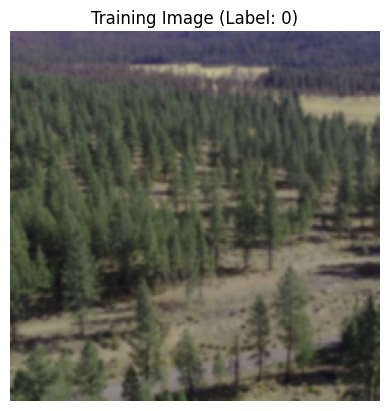


Displaying a sample image from the test set:


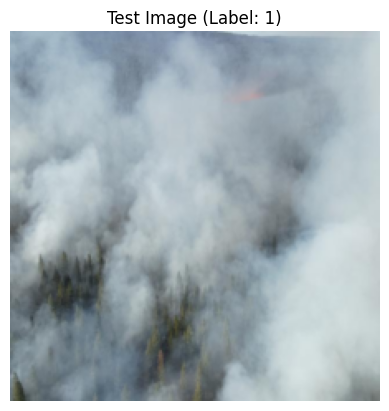

In [ ]:
# Displaying an image
def imshow(img, title=None):
    # Unnormalize the image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_np = img.numpy().transpose((1, 2, 0)) # Convert from (C, H, W) to (H, W, C)
    img_unnormalized = img_np * std + mean

    # Display the image
    plt.imshow(img_unnormalized.clip(0, 1)) # Clip values to be between 0 and 1
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.show()

# Access and display a sample image from the training set
print("Displaying a sample image from the training set:")
sample_train_image, sample_train_label = train_dataset[10]
imshow(sample_train_image, title=f"Training Image (Label: {sample_train_label})")

# Access and display a sample image from the test set
print("\nDisplaying a sample image from the test set:")
sample_test_image, sample_test_label = test_dataset[2]
imshow(sample_test_image, title=f"Test Image (Label: {sample_test_label})")